In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
import matplotlib.pyplot as plt
import plotly.express as px

#scikit-learn related imports
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import (
    IntegratedGradients,
    DeepLift,
    DeepLiftShap,
    GradientShap,
    NoiseTunnel,
    FeatureAblation,
    Saliency,
    InputXGradient,
    Deconvolution,
    FeaturePermutation
)
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import NeuronConductance

## Data loading and pre-processing

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
n = 10000 # subset

dataset = fetch_california_housing()
feature_names = dataset.feature_names
X = dataset.data[:n,:]
y = dataset.target[:n]
print(X.shape, y.shape)

(10000, 8) (10000,)


In order to retain deterministic results, let's fix the seeds.

In [4]:
torch.manual_seed(1234)
np.random.seed(1234)

# Data Exploration

Let's visualize dependent variable vs each independent variable in a separate plot. Apart from that we will also perform a simple regression analysis and plot the fitted line in dashed, red color.

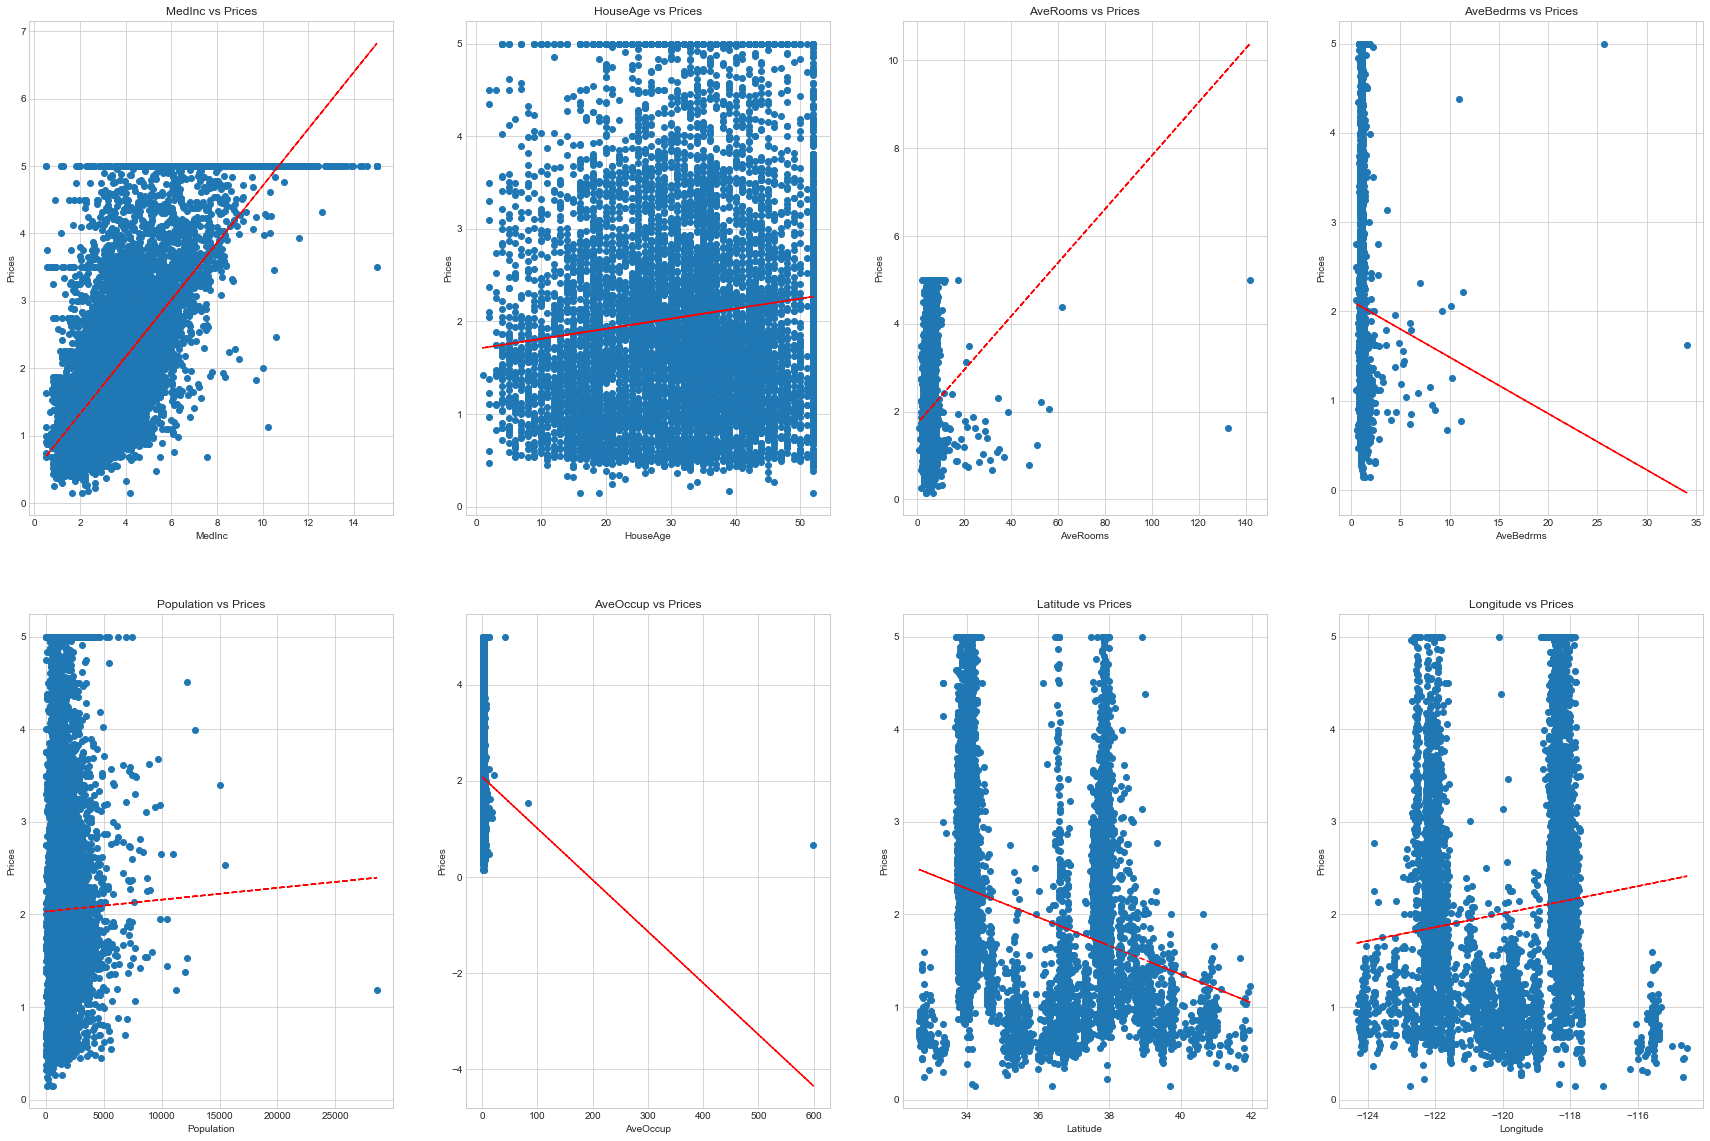

In [5]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows = 2, ncols=4, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')

Remove abnormalities and repeat train test split
* `Prices` == 5 don't have a clear relationship;
* `House Age` = 52

In [6]:
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target
print(df.shape)
constr = (df['target'] < 5) & (df['HouseAge'] < 52) & (df['AveOccup'] < 80)
df = df.loc[constr]
print(df.shape)

X = df[feature_names].values[:n,:]
y = df['target'].values[:n]
print(X.shape, y.shape)

(20640, 9)
(18551, 9)
(10000, 8) (10000,)


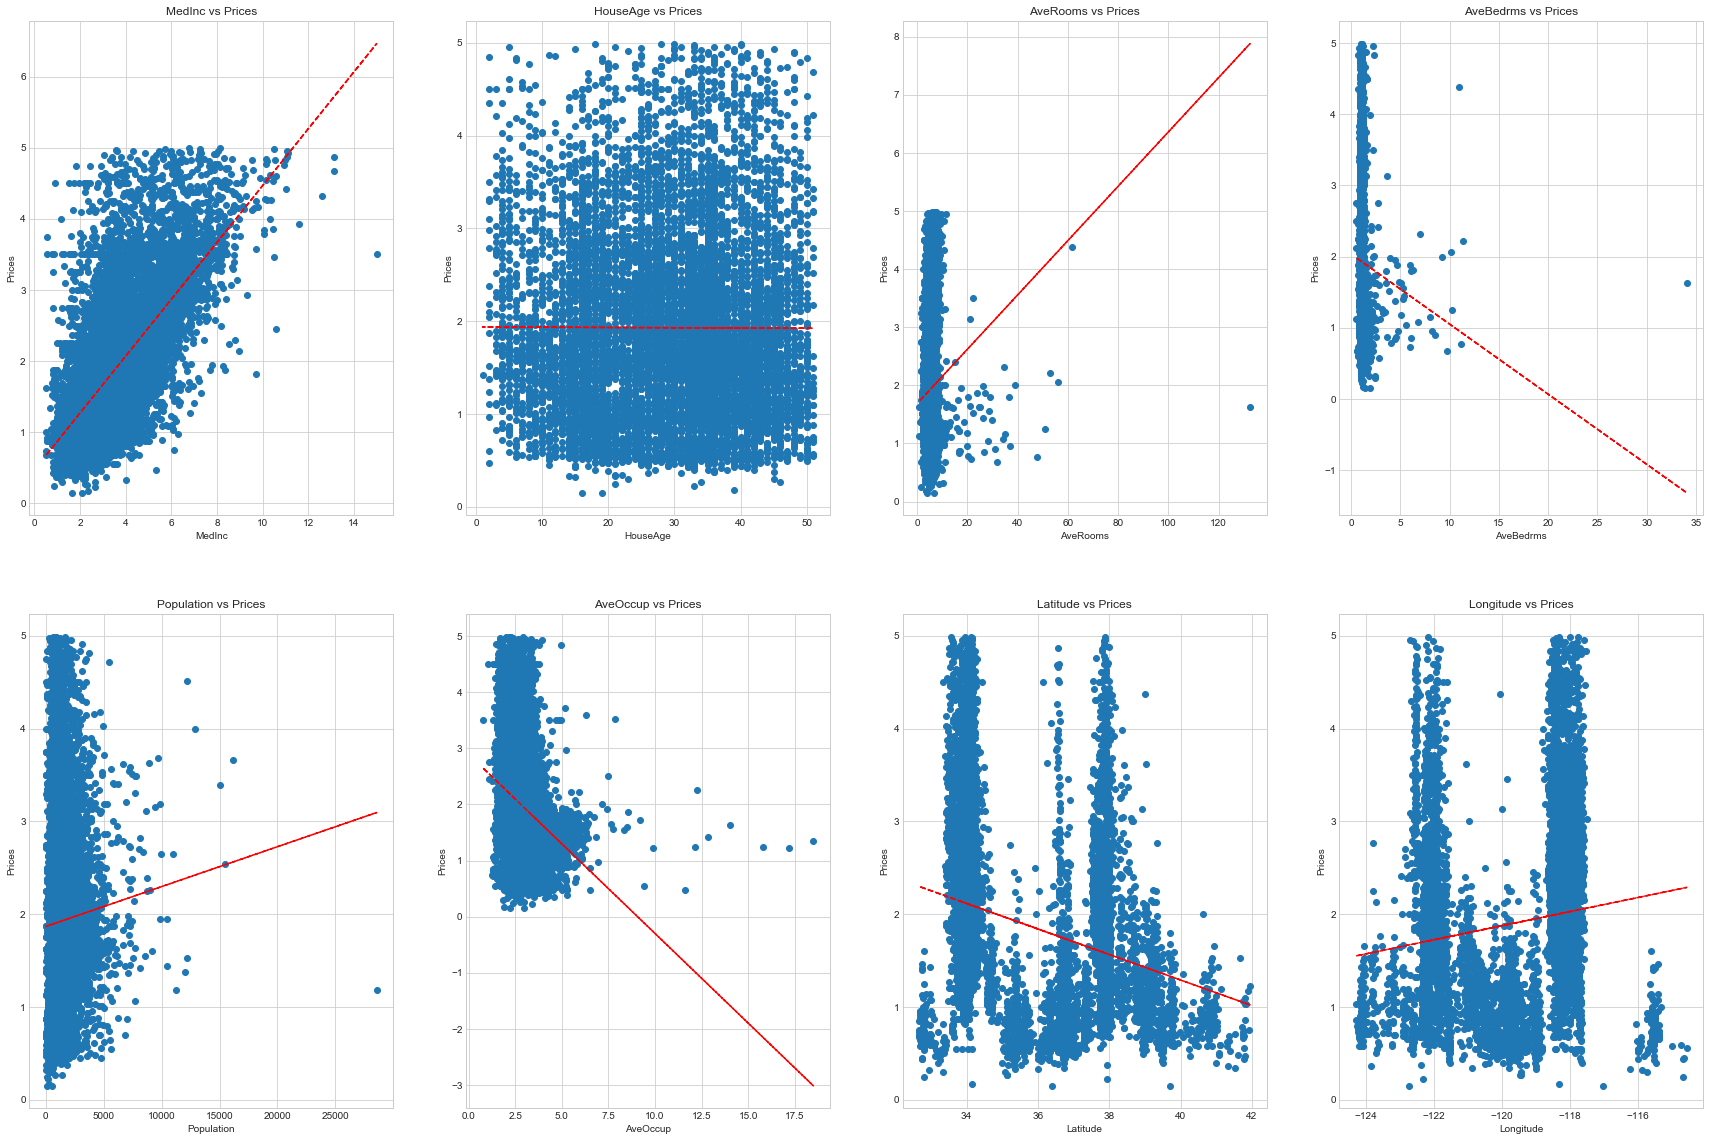

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols=4, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')

Let's use:
* 70% of our data for training;
* 10% for validation;
* 20% for testing.

In [8]:
np.random.seed(0)
n = X.shape[0]
tr_n, val_n, ts_n = int(0.7*n), int(0.8*n), int(1*n)
seq = np.arange(0, n)
np.random.shuffle(seq)
X_train, X_val, X_test = X[:tr_n,:], X[tr_n:val_n,:], X[val_n:ts_n,:]
y_train, y_val, y_test = y[:tr_n], y[tr_n:val_n], y[val_n:ts_n]
X_train.shape, X_val.shape, X_test.shape

((7000, 8), (1000, 8), (2000, 8))

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

`MedInc` seems to be an important feature, linear relationship with `Price` seems pretty strong. But there could be important nonlinear relationships which NN could find.

# Tensorizing inputs and creating batches

Below we tensorize input features and corresponding labels.

In [10]:
X_train = torch.tensor(X_train).to(device).float()
y_train = torch.tensor(y_train).to(device).view(-1, 1).float()

X_val = torch.tensor(X_val).to(device).float()
y_val = torch.tensor(y_val).to(device).view(-1, 1).float()

X_test = torch.tensor(X_test).to(device).float()
y_test = torch.tensor(y_test).to(device).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

datasets_val = torch.utils.data.TensorDataset(X_val, y_val)
validation_iter = torch.utils.data.DataLoader(datasets_val, batch_size=10, shuffle=True)

Defining default hyper parameters for the model.


In [11]:
batch_size = 50
num_epochs = 60
learning_rate = 0.001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

We define a four layer neural network containing ReLUs between each linear layer. This network is slightly more complex than the standard linear regression model and results in a slightly better accuracy.

In [12]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(8, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [13]:
model = HousingModel()
model.train()

HousingModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

## Train Housing Model

Defining the loss function that will be used for optimization.

In [14]:
criterion = nn.MSELoss(reduction='mean')

Defining the training function that contains the training loop and uses RMSprop and given input hyper-parameters to train the model defined in the cell above.

In [15]:
def train(model_inp, num_epochs = num_epochs):
    
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    Epochs, Losses = [], []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times     

        #iterate over TRAINING set
        running_loss = 0.0
        
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        
        Epochs.append(epoch)
        Losses.append(running_loss)       
  
        if epoch % 20 == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

        
    fig = px.scatter(
        x=Epochs,
        y=Losses,
        template='ggplot2',
        trendline='lowess',
        labels={"x":"epoch", "y":"running loss"}
    )
    display(fig)

If the model was previously trained and stored, we load that pre-trained model, otherwise, we train a new model and store it for future uses.

In [16]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path, map_location=device))
    else:    
        # train model
        train(model_obj.to(device))
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [17]:
SAVED_MODEL_PATH = 'housing_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: housing_model.pt


In [18]:
criterion = nn.MSELoss(reduction='mean')
for n in np.arange(0,1000,100): 

    m1 = criterion(y_train.cuda()[:n], model.cuda()(X_train.cuda()[:n,:]))
    print(m1.item())

nan
0.19402572512626648
0.15183104574680328
0.19219592213630676
0.23894530534744263
0.22790613770484924
0.22885850071907043
0.23867924511432648
0.26171237230300903
0.23879987001419067


In [19]:
n = y_val.shape[0]

m1 = criterion(y_train.cuda()[:n], model.cuda()(X_train.cuda()[:n,:]))
m2 = criterion(y_val, model(X_val))
m3 = criterion(y_test, model(X_test))
print(f"""
Training Error: {m1.item()},
Validation Error: {m2.item()},
Testing Error: {m3.item()}
"""
)


Training Error: 0.2219860702753067,
Validation Error: 0.4488704800605774,
Testing Error: 0.4531608521938324



In [20]:
model.eval()

HousingModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
metrics_device = 'cpu'
model.to(metrics_device).eval()
outputs = model(X_test.to(metrics_device))

err = np.sqrt(mean_squared_error(
     outputs.to(metrics_device).detach().numpy(),
     y_test.to(metrics_device).detach().numpy())
)
# Revert back to device
X_test.to(device)
y_test.to(device)
model.to(device)
print('model err: ', err)

model err:  0.67317224


          y_true     y_hat
y_true  1.000000  0.761387
y_hat   0.761387  1.000000


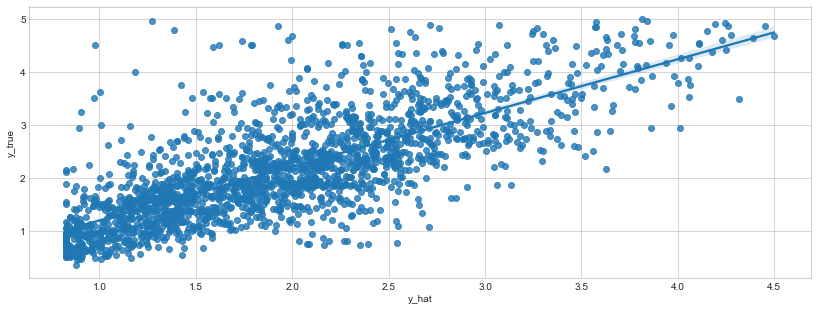

In [22]:
# predictions correlation for sense check
y_hat = outputs.to(metrics_device).detach().numpy()
y_true = y_test.to(metrics_device).detach().numpy()
results = pd.DataFrame()
results['y_true'] = y_true[:,0]
results['y_hat'] = y_hat[:,0]
print(results.corr(method='pearson'))

# visualization
plt.rcParams['figure.figsize'] = 14,5
sns.regplot(x='y_hat', y='y_true', data=results)
plt.show()

## 1. Primary Attributions

#### Comparing different attribution algorithms

Note: This takes time.

In [23]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)
dls = DeepLiftShap(model)
sl = Saliency(model)
ixg = InputXGradient(model)
dc = Deconvolution(model)
fp = FeaturePermutation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)
#dls_attr_test = dls.attribute(X_test, X_train)
sl_attr_test = sl.attribute(X_test)
ixg_attr_test = ixg.attribute(X_test)
dc_attr_test = dc.attribute(X_test)
fp_attr_test = fp.attribute(X_test)

C:\Users\mariu\anaconda3\lib\site-packages\captum\attr\_utils\gradient.py:33: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

C:\Users\mariu\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:301: UserWarning:

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished

C:\Users\mariu\anaconda3\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:56: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished



In [24]:
# check what is happening with gpu memory
from pytorch_memlab import profile, set_target_gpu, MemReporter
reporter = MemReporter()
reporter.report()

Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cuda:0
Tensor0                                            (2000, 8)    62.50K
Tensor1                                            (2000, 8)    62.50K
Tensor2                                            (7000, 8)   219.00K
Tensor3                                            (7000, 1)    27.50K
Tensor4                                            (1000, 8)    31.50K
Tensor5                                            (1000, 1)     4.00K
Tensor6                                            (2000, 8)    62.50K
Tensor7                                            (2000, 1)     8.00K
Tensor8                                                 (1,)   512.00B
Tensor9                                                 (1,)   512.00B
Tensor10                                                (1,)   512.00B
Parameter11                                       

In [25]:
torch.cuda.empty_cache()

In [26]:
# prepare attributions for visualization
def attributions_sum(attr_test):

    attr_test_sum = attr_test.cpu().detach().numpy().sum(0)
    attr_test_norm_sum = attr_test_sum / np.linalg.norm(attr_test_sum, ord=1)
    
    return attr_test_norm_sum

attribution_dict = {
 'Int Grads' : ig_attr_test,
 'Int Grads w/SmoothGrad' : ig_nt_attr_test,
 'DeepLift' : dl_attr_test,
 #'DeepLiftSHAP' : dls_attr_test,
 'GradientSHAP' : gs_attr_test,
 'Feature Ablation' : fa_attr_test,
 'Saliency' : sl_attr_test,
 'InputXGradient' : ixg_attr_test,
 'Deconvolution': dc_attr_test,
 'FeaturePermutation': fp_attr_test
}

to_plot = pd.DataFrame()
to_plot['Features'] = feature_names

for name, attr_test in attribution_dict.items():
        
    to_plot[name] = attributions_sum(attr_test)

# Calculate weigths differently
lin_weight = model.cpu().lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)    
to_plot['Weights'] = y_axis_lin_weight
# Some correlations
correlations = to_plot
correlations.index = to_plot['Features'].values
correlations = correlations.drop('Features',axis=1)
correlations = correlations.corr()

to_plot = pd.melt(to_plot, id_vars='Features')
to_plot.sample(5,random_state=0)

Features        variable     value
50   AveRooms  InputXGradient -0.051770
27  AveBedrms    GradientSHAP  0.006168
30   Latitude    GradientSHAP  0.017290
77   AveOccup         Weights  0.097162
45   AveOccup        Saliency  0.329859

In [27]:
# visualize
px.bar(
    data_frame=to_plot,
    x='value',
    y='variable',
    facet_col='Features',
    facet_col_wrap=2,
    color='variable',
    orientation='h',
    height=1000,
    width=950,
    template='ggplot2'
)

## 2. Layer Attributions

#### Attributing to the layers and comparing with model weights

Now let's beside attributing to the inputs of the model, also attribute to the layers of the model and understand which neurons appear to be more important.

In the cell below we will attribute to the inputs of the second linear layer of our model. Similar to the previous case, the attribution is performed on the test dataset.

In the cell below we normalize and visualize the attributions and learned model weights for all 10 neurons in the fourth hidden layer. 
The weights represent the weight matrix of the fourth linear layer. The attributions are computed with respect to the inputs of the fourth linear layer.

In [28]:
lc = LayerConductance(model.to(device), model.lin4)
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# shape: test_examples x size_hidden
lc_attr_test = lc_attr_test[0]

# weights from fourth linear layer
# shape: size_hidden4 x size_hidden3
lin4_weight = model.lin4.weight

y_axis_lc_attr_test = lc_attr_test.cpu().mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin4_weight = lin4_weight.cpu()[0].detach().numpy()
y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)

x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]

results = pd.DataFrame()
results["Neurons"] = x_axis_labels  
results["Attributions"] = y_axis_lc_attr_test
results["Weights"] = y_axis_lin4_weight
results = pd.melt(results, id_vars=["Neurons"])
results.sample(5,random_state=0)

Neurons      variable     value
18  Neuron 8       Weights  0.041015
1   Neuron 1  Attributions  0.000273
19  Neuron 9       Weights -0.056768
8   Neuron 8  Attributions  0.081188
10  Neuron 0       Weights  0.000562

In [29]:
# visualize
px.bar(
    data_frame=results,
    x='Neurons',
    y='value',
    color='variable',
    orientation='v',
    height=500,
    width=950,
    template='ggplot2',
    barmode='group'
)

In [30]:
layers = ['lin1', 'lin2', 'lin3', 'lin4']

for l in layers:
    
    layer = getattr(model,l)
    
    lc = LayerConductance(model.to(device), layer)
    lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

    # shape: test_examples x size_hidden
    lc_attr_test = lc_attr_test[0]

    # weights from fourth linear layer
    lin_weight = layer.weight

    y_axis_lc_attr_test = lc_attr_test.cpu().mean(0).detach().numpy()
    y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

    y_axis_lin_weight = lin_weight.cpu()[0].detach().numpy()
    y_axis_lin_weight = y_axis_lin_weight / np.linalg.norm(y_axis_lin_weight, ord=1)

    x_axis_labels = ['Neuron {}'.format(i) for i in range(len(y_axis_lin_weight))]

    results = pd.DataFrame()
    results["Neurons"] = x_axis_labels  
    results["Attributions"] = y_axis_lc_attr_test
    results["Weights"] = y_axis_lin_weight
    results = pd.melt(results, id_vars=["Neurons"])

    # visualize
    fig = px.bar(
        data_frame=results,
        x='Neurons',
        y='value',
        color='variable',
        orientation='v',
        height=500,
        width=950,
        template='ggplot2',
        barmode='group',
        labels={'value':''},
        title=f"Layer: {l} ({layer.in_features} features)"
    )
    display(fig)
       
    #save plots to make a gif
    fig.write_image(l+".png", height=700, width=950)

In [32]:
from pathlib import Path
from PIL import Image
import imageio

name = "layear_attributions.gif"
image_path = Path('')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite(name, image_list, duration=2)

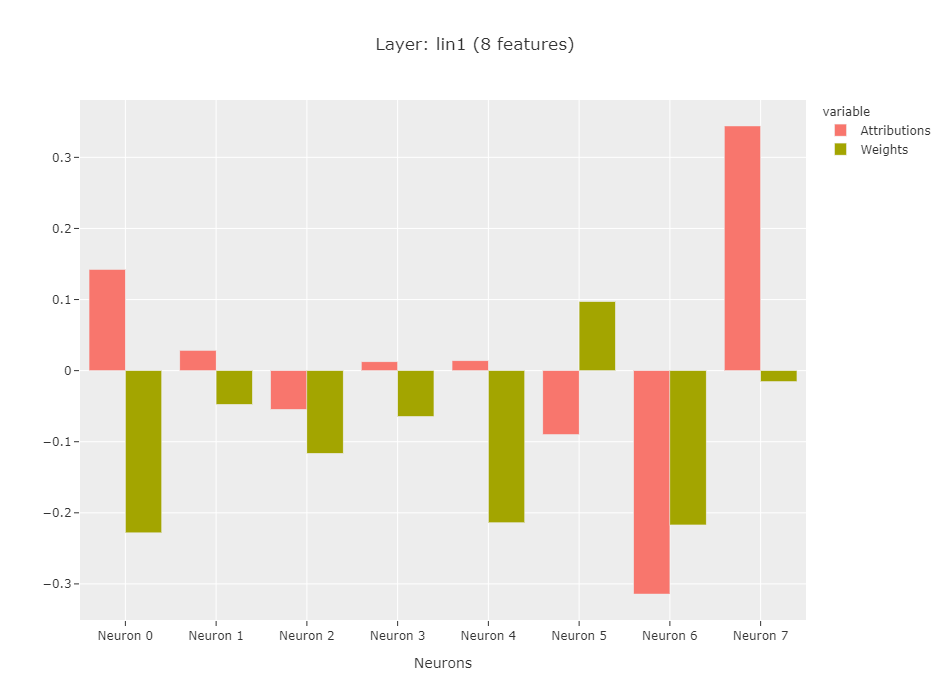

In [33]:
from IPython.display import display, Image
with open(name,'rb') as f:
    display(Image(data=f.read(), format='png'))

## 3. Neuron Atrributions

It is interesting to observe that the weights and attribution scores are well aligned for all 10 neurons in the last layer. Meaning that the neurons with negative weights also have negative attribution scores and we can observe the same for the positive weights and attributions. 

In [34]:
neuron_cond = NeuronConductance(model, model.lin3)
test_input_tensor = X_test
print(test_input_tensor.shape)

torch.Size([2000, 8])


In [35]:
inds = [0,2,8]
neuron_cond_vals_importance = pd.DataFrame()
neuron_cond_vals_importance['features'] = feature_names

for ind in inds:
    
    neuron_cond_vals = neuron_cond.attribute(test_input_tensor, neuron_index=ind)
    neuron_cond_vals_importance[f'Neuron {ind}'] = neuron_cond_vals.cpu().mean(dim=0).detach().numpy()
    
neuron_cond_vals_importance = pd.melt(neuron_cond_vals_importance, id_vars='features')

In [36]:
px.bar(
    data_frame=neuron_cond_vals_importance,
    x='features',
    y='value',
    color='variable',
    barmode='group',
    template='ggplot2'
)